Device is cpu.
36 256

SAINT (transformer):
MSE:  6.983201621093368e+18
R²:  0.5806585640855162


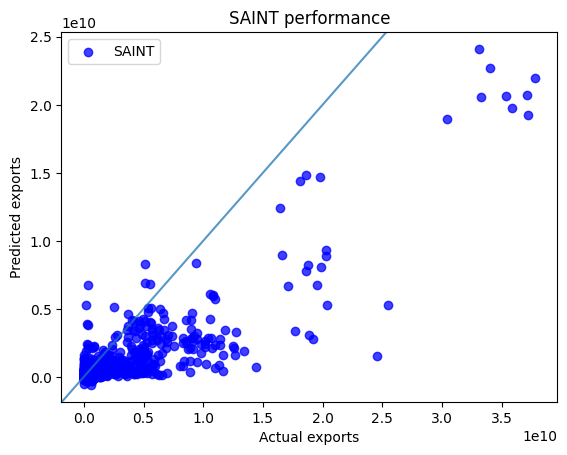

In [3]:
import torch
from models import SAINT

from data_openml import data_prep_openml, DataSetCatCon
from utils import generate_outputs
import argparse
from torch.utils.data import DataLoader

import os
import numpy as np
from itertools import chain
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser()

parser.add_argument('--vision_dset', action = 'store_true')
parser.add_argument('--task', type=str,choices = ['binary','multiclass','regression'], default='regression')
parser.add_argument('--cont_embeddings', default='MLP', type=str,choices = ['MLP','Noemb','pos_singleMLP'])
parser.add_argument('--embedding_size', default=32, type=int)
parser.add_argument('--transformer_depth', default=1, type=int)
parser.add_argument('--attention_heads', default=4, type=int)
parser.add_argument('--attention_dropout', default=0.1, type=float)
parser.add_argument('--ff_dropout', default=0.1, type=float)
parser.add_argument('--attentiontype', default='colrow', type=str,choices = ['col','colrow','row','justmlp','attn','attnmlp'])

parser.add_argument('--optimizer', default='AdamW', type=str,choices = ['AdamW','Adam','SGD'])
parser.add_argument('--scheduler', default='cosine', type=str,choices = ['cosine','linear'])

parser.add_argument('--lr', default=0.0001, type=float)
parser.add_argument('--epochs', default=100, type=int)
parser.add_argument('--batchsize', default=256, type=int)
parser.add_argument('--savemodelroot', default='./bestmodels', type=str)
parser.add_argument('--run_name', default='testrun', type=str)
parser.add_argument('--set_seed', default= 1 , type=int)
parser.add_argument('--dset_seed', default= 5 , type=int)

parser.add_argument('--pretrain', action = 'store_true')
parser.add_argument('--pretrain_epochs', default=50, type=int)
parser.add_argument('--pt_tasks', default=['contrastive','denoising'], type=str,nargs='*',choices = ['contrastive','contrastive_sim','denoising'])
parser.add_argument('--pt_aug', default=[], type=str,nargs='*',choices = ['mixup','cutmix'])
parser.add_argument('--pt_aug_lam', default=0.1, type=float)
parser.add_argument('--mixup_lam', default=0.3, type=float)

parser.add_argument('--train_mask_prob', default=0, type=float)
parser.add_argument('--mask_prob', default=0, type=float)

parser.add_argument('--ssl_avail_y', default= 0, type=int)
parser.add_argument('--pt_projhead_style', default='diff', type=str,choices = ['diff','same','nohead'])
parser.add_argument('--nce_temp', default=0.7, type=float)

parser.add_argument('--lam0', default=0.5, type=float)
parser.add_argument('--lam1', default=10, type=float)
parser.add_argument('--lam2', default=1, type=float)
parser.add_argument('--lam3', default=10, type=float)
parser.add_argument('--final_mlp_style', default='sep', type=str,choices = ['common','sep'])

opt = parser.parse_args(args=[])
modelsave_path = os.path.join(os.getcwd(),opt.savemodelroot,opt.task,"saint",opt.run_name)
if opt.task == 'regression':
    opt.dtask = 'reg'
else:
    opt.dtask = 'clf'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}.")

torch.manual_seed(opt.set_seed)
os.makedirs(modelsave_path, exist_ok=True)

cat_dims, cat_idxs, con_idxs, X_train, y_train, X_valid, y_valid, X_test, y_test, train_mean, train_std, y_mean, y_std = data_prep_openml()
continuous_mean_std = np.array([train_mean,train_std]).astype(np.float32) 

_,nfeat = X_train['data'].shape

print(nfeat,opt.batchsize)

if device == 'cpu':
    num_workers = 4
else:
    num_workers = 2

train_ds = DataSetCatCon(X_train, y_train, cat_idxs,opt.dtask,continuous_mean_std)
trainloader = DataLoader(train_ds, batch_size=opt.batchsize, shuffle=True,num_workers=num_workers)

test_ds = DataSetCatCon(X_test, y_test, cat_idxs,opt.dtask, continuous_mean_std)
testloader = DataLoader(test_ds, batch_size=opt.batchsize, shuffle=False,num_workers=num_workers)
if opt.task == 'regression':
    y_dim = 1
else:
    y_dim = len(np.unique(y_train['data'][:,0]))

cat_dims = np.append(np.array([1]),np.array(cat_dims)).astype(int) #Appending 1 for CLS token, this is later used to generate embeddings.


model = SAINT(
    categories = tuple(cat_dims), 
    num_continuous = len(con_idxs),
    dim = opt.embedding_size,
    dim_out = 1,
    depth = opt.transformer_depth,
    heads = opt.attention_heads,
    attn_dropout = opt.attention_dropout,
    ff_dropout = opt.ff_dropout,
    mlp_hidden_mults = (4, 2),
    cont_embeddings = opt.cont_embeddings,
    attentiontype = opt.attentiontype,
    final_mlp_style = opt.final_mlp_style,
    y_dim = y_dim
)

vision_dset = opt.vision_dset
model.to(device)

state_dict = torch.load("bestmodels/{}/saint/testrun/bestmodel.pth".format(opt.task), map_location=device)
model.load_state_dict(state_dict)


y_pred, y_test = generate_outputs(model, testloader, device, opt.task,vision_dset)
if opt.task == 'regression':
    y_test = (y_test * y_std) + y_mean
    y_pred = (y_pred * y_std) + y_mean
    y_pred = list(chain(*y_pred.tolist()))
else:
    y_pred = y_pred.tolist()
y_test = y_test.tolist()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nSAINT (transformer):")
print("MSE: ", mse)
print("R²: ", r2)

# Plot the results
plt.scatter(y_test, y_pred, label='SAINT', color='blue', alpha=0.75)
plt.axline((0, 0), slope=1, alpha=0.75)
plt.xlabel("Actual exports")
plt.ylabel("Predicted exports")
plt.legend()
plt.title("SAINT performance")
plt.show()